# Chapitre 9
##### 9.1.1 Selection variable pour algorithme de regression

In [1]:
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
datasets = pds.read_excel("dataset.xlsx", index_col="Date", parses_date=True)
datasets

,AMZN,BRENT,CAC40,NQ100,DJI30,DAX30,GOLD,EURUSD
Date,,,,,,,,
2012.03.16,183.16,122.50,3576.00,2712.80,13231.00,7150.40,1657.75,1.30750
2012.03.19,183.25,125.80,3592.60,2716.60,13237.00,7157.10,1660.05,1.31770
2012.03.20,183.51,125.39,3571.20,2730.90,13228.00,7145.30,1663.05,1.32280
2012.03.21,192.06,124.19,3541.80,2736.10,13175.00,7062.90,1649.65,1.32390
2012.03.22,190.33,123.97,3524.50,2739.20,13140.00,7065.70,1651.45,1.32180
...,...,...,...,...,...,...,...,...
2019.07.03,1936.98,63.32,5583.39,7812.23,26791.84,12553.78,1418.15,1.12852
2019.07.05,1930.18,63.94,5616.53,7870.32,26980.84,12628.73,1415.83,1.12826
2019.07.08,1932.30,64.97,5572.78,7831.21,26902.11,12567.28,1398.43,1.12234


In [52]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)

from sklearn.linear_model import LinearRegression

rl = LinearRegression()

rl.fit(Xtrain_sc, ytrain_sc)
y_pred = sc.inverse_transform(rl.predict(Xvisu_sc))

y_pred = y_pred.reshape(len(y_pred),1)

pds.DataFrame(X_train.var(axis=0), index = X.columns.to_list(), columns=["Variance"])*100

,Variance
AMZN,0.033309
BRENT,0.037060
CAC40,0.014319
NQ100,0.008883
DJI30,0.005438
DAX30,0.014140
GOLD,0.009767
EURUSD,0.003150


In [53]:
##### Selection variable avec la variance

from sklearn.feature_selection import VarianceThreshold


selecteur = VarianceThreshold(threshold=0.03/100)
selecteur.fit_transform(X_train)

pds.DataFrame(selecteur.get_support().transpose(),index=datasets.columns.tolist(), columns=["Selection"])

,Choisie
AMZN,True
BRENT,True
CAC40,False
NQ100,False
DJI30,False
DAX30,False
GOLD,False
EURUSD,False


In [54]:
##### Selection variable avec coefficient de corrélation
from sklearn.feature_selection import SelectKBest, f_regression

selecteur = SelectKBest(f_regression, k=5)

selecteur.fit(X_train,y_train)
selecteur.get_support()

pds.DataFrame(selecteur.get_support(), index = datasets.columns.tolist(), columns=["Selection"]).transpose()

,AMZN,BRENT,CAC40,NQ100,DJI30,DAX30,GOLD,EURUSD
Selection,True,True,False,False,False,True,True,True


In [77]:
######## MODELE AVEC LES VARIBLES SELECTIONNEES PAR SELECTKBEST

##### Scindage de la base de données en X et y
X = datasets[["AMZN","CAC40","NQ100",
              "DJI30", "DAX30"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values*1000
X_visu = X.iloc[1400:1750-1,:].values*1000

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)


from sklearn.linear_model import LinearRegression

rl = LinearRegression()

rl.fit(Xtrain_sc, ytrain_sc)
y_skb = sc.inverse_transform(rl.predict(Xvisu_sc))

y_skb = y_skb.reshape(len(y_skb),1)

In [78]:
def mesure_gain(tx_pred, tx_visu, sb=0.00, sh=0.00, spread=0.00050, levier=1):
    # Initialisation
    l = len(tx_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    count_true = 0
    count_false = 0
    p = 0
    
    #Gain
    for i in range(l):
        if tx_pred[i][0]>sh:
            gain[i][0] = (tx_visu[i][0]-spread)*levier
            hausse[i][0] = (tx_visu[i][0]-spread)*levier
        if tx_pred[i][0]<-sb:
            gain[i][0] = (-tx_visu[i][0]-spread)*levier
            baisse[i][0] = (-tx_visu[i][0]-spread)*levier
    
    # Affichage
    moyenne = np.mean(gain[gain!=0])
    ecart_type = np.std(gain[gain!=0])
    
    # Croissance
    coef = 1
    coef_ = np.zeros(l).reshape(l,1)

    for i in range(l):
        coef *= (1+gain[i][0])
        coef_[i][0] = coef
        
    pourcentage = (coef-1)*100
    
    
    sharpe = moyenne/ecart_type
    
    sortino = np.mean(gain[gain!=0])/np.std(gain[gain<0])
    
    #Mesures
    somme_gain_h = round(sum(hausse)[0]*100,2)
    somme_gain_b = round(sum(baisse)[0]*100,2)
    
    
    gain_max_hausse = round(np.max(hausse, axis=0)[0]*100,2)
    gain_min_hausse = round(np.min(hausse, axis=0)[0]*100,2)
    
    
    gain_max_baisse = round(np.max(baisse, axis=0)[0]*100,2)
    gain_min_baisse = round(np.min(baisse, axis=0)[0]*100,2)
    
    
    print("------------------ Données de bases -----------------------")
    print("Seuil_hausse:", sh)
    print("Seuil_baisse:", sb)
    print("Spred", spread)
    print("Effet de levier:",levier)
    print("                                                           ")
    print("---------------------- Mesures ----------------------------")
    print("Pourcentage sur la période:", round(np.sum(gain)*100,2), "%")
    print("Poucentage composé:", round(pourcentage,2), "%")
    print("Ratio gain par trade:", round(moyenne*100,2), "%")
    print("Écart-type des gains:", round(ecart_type*100,2), "%")
    print("Ratio Sharpe:", round(sharpe,6))
    print("Ratio Sortino:", round(sortino,6))
    print("                                                           ")
    print("-------------------- Autres données -----------------------")
    print("Somme des gains à la hausse:", somme_gain_h, "%")
    print("Somme des gains à la baisse:", somme_gain_b, "%")
    print("gain max a la hausse:",gain_max_hausse, "%")
    print("gain min a la hausse:",gain_min_hausse, "%")
    print("gain max a la baisse:",gain_max_baisse, "%")
    print("gain min a la baisse:",gain_min_baisse, "%")
    print("                                                           ")
    print("-------------------- Distribution -----------------------")
    plt.title("Distribution gain")
    plt.hist(gain[gain!=0]*100,bins=55)
    plt.axvline(0, color="black")
    plt.xlabel("Pourcentage gain")
    plt.show()
    print("                                                           ")
    print("-------------------- Croissance -----------------------")
    plt.plot((coef_-1)*100,color="green")
    plt.title("Croissance Portefeuille")
    plt.ylabel("Gain(pourcentage)")
    plt.show()
    



------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spred 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 35.59 %
Poucentage composé: 40.02 %
Ratio gain par trade: 0.12 %
Écart-type des gains: 1.14 %
Ratio Sharpe: 0.106174
Ratio Sortino: 0.140124
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 35.59 %
Somme des gains à la baisse: 0.0 %
gain max a la hausse: 4.43 %
gain min a la hausse: -3.62 %
gain max a la baisse: 0.0 %
gain min a la baisse: 0.0 %
                                                           
-------------------- Distribution -----------------------


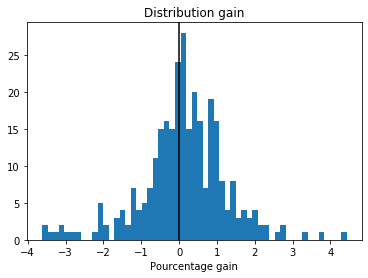

                                                           
-------------------- Croissance -----------------------


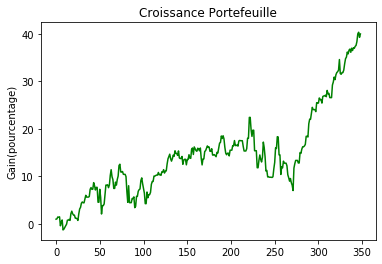

In [79]:
###### Gain obtenue sans utilisation de SelectKBest

mesure_gain(y_pred, y_visu)

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spred 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 52.76 %
Poucentage composé: 65.33 %
Ratio gain par trade: 0.15 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.127607
Ratio Sortino: 0.188284
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 34.72 %
Somme des gains à la baisse: 18.04 %
gain max a la hausse: 3.73 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -4.53 %
                                                           
-------------------- Distribution -----------------------


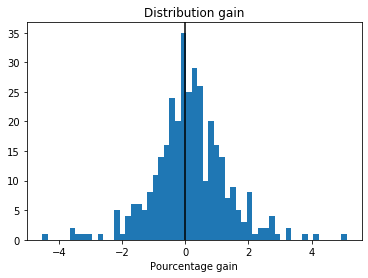

                                                           
-------------------- Croissance -----------------------


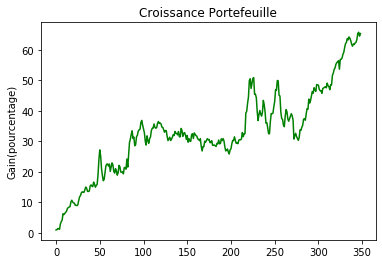

In [80]:
###### Gain obtenue sans utilisation de SelectKBest

mesure_gain(y_pred, y_visu)

###### Gain obtenue avec utilisation de SelectKBest

mesure_gain(y_skb, y_visu)

##### 9.1.2 Selection variables pour algorithme de classification

In [59]:
datasets_pct = datasets.pct_change(1).dropna().reset_index(drop=True)
datasets_pct["Étiquetage"] = np.round(datasets_pct["NQ100"]+0.5)

In [90]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain_sc, y_train)
y_pred = lr.predict(Xvisu_sc)
y_pred = y_pred.reshape(len(y_pred),1)

In [91]:
##### Selection variable avec anova-value

from sklearn.feature_selection import SelectKBest, f_classif


selecteur = SelectKBest(f_classif, k=5)

selecteur.fit(Xtrain_sc,y_train)
selecteur.get_support()

pds.DataFrame(selecteur.get_support(), index = X.columns.tolist(), columns=["Selection"]).transpose()

,AMZN,BRENT,CAC40,NQ100,DJI30,DAX30,GOLD,EURUSD
Selection,True,True,False,False,True,True,True,False


In [92]:
###### MODELE AVEC LES VARIABLES CHOISIES PAR SELECTKBEST


##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT",
              "DJI30", "DAX30", "GOLD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain_sc, y_train)
y_skb = lr.predict(Xvisu_sc)
y_skb = y_skb.reshape(len(y_skb),1)

In [11]:
def mesure_classifieur(y_pred, tx_visu, spread=0.00050, levier=1):
    # Initialisation
    l = len(y_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    count_true = 0
    count_false = 0
    p = 0
    y_pred = y_pred.reshape(len(y_pred),1)
    #Gain
    for i in range(l):
        if y_pred[i][0]==1:
            gain[i][0] = (tx_visu[i][0]-spread)*levier
            hausse[i][0] = (tx_visu[i][0]-spread)*levier
        if y_pred[i][0]==0:
            gain[i][0] = (-tx_visu[i][0]-spread)*levier
            baisse[i][0] = (-tx_visu[i][0]-spread)*levier
    
    # Affichage
    moyenne = np.mean(gain[gain!=0])
    ecart_type = np.std(gain[gain!=0])
    
    # Croissance
    coef = 1
    coef_ = np.zeros(l).reshape(l,1)

    for i in range(l):
        coef *= (1+gain[i][0])
        coef_[i][0] = coef
        
    pourcentage = (coef-1)*100
    
    
    sharpe = moyenne/ecart_type
    
    sortino = np.mean(gain[gain!=0])/np.std(gain[gain<0])
    
    #Mesures
    somme_gain_h = round(sum(hausse)[0]*100,2)
    somme_gain_b = round(sum(baisse)[0]*100,2)
    
    
    gain_max_hausse = round(np.max(hausse, axis=0)[0]*100,2)
    gain_min_hausse = round(np.min(hausse, axis=0)[0]*100,2)
    
    
    gain_max_baisse = round(np.max(baisse, axis=0)[0]*100,2)
    gain_min_baisse = round(np.min(baisse, axis=0)[0]*100,2)
    
    
    
    
    print("------------------ Données de bases -----------------------")
    print("Spread", spread)
    print("Effet de levier:",levier)
    print("                                                           ")
    print("---------------------- Mesures ----------------------------")
    print("Pourcentage sur la période:", round(np.sum(gain)*100,2), "%")
    print("Poucentage composé:", round(pourcentage,2), "%")
    print("Ratio gain par trade:", round(moyenne*100,2), "%")
    print("Écart-type des gains:", round(ecart_type*100,2), "%")
    print("Ratio Sharpe:", round(sharpe,6))
    print("Ratio Sortino:", round(sortino,6))
    print("                                                           ")
    print("-------------------- Autres données -----------------------")
    print("Somme des gains à la hausse:", somme_gain_h, "%")
    print("Somme des gains à la baisse:", somme_gain_b, "%")
    print("gain max a la hausse:",gain_max_hausse, "%")
    print("gain min a la hausse:",gain_min_hausse, "%")
    print("gain max a la baisse:",gain_max_baisse, "%")
    print("gain min a la baisse:",gain_min_baisse, "%")
    print("                                                           ")
    print("-------------------- Distribution -------------------------")
    plt.title("Distribution gain")
    plt.hist(gain[gain!=0]*100,bins=55)
    plt.axvline(0, color="black")
    plt.xlabel("Pourcentage gain")
    plt.show()
    print("                                                           ")
    print("-------------------- Croissance ---------------------------")
    plt.plot((coef_-1)*100,color="green")
    plt.title("Croissance Portefeuille")
    plt.ylabel("Gain(pourcentage)")
    plt.show()



------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 59.19 %
Poucentage composé: 76.32 %
Ratio gain par trade: 0.17 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.143554
Ratio Sortino: 0.204639
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 35.59 %
Somme des gains à la baisse: 23.6 %
gain max a la hausse: 4.43 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -----------------------


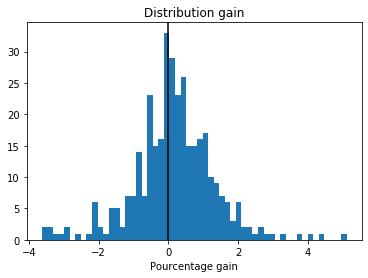

                                                           
-------------------- Croissance -----------------------


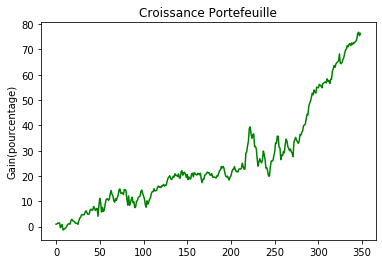

In [94]:
##### Gain obtenue sans SelectKBest
##### On prend les pourcentages du NQ100 pour calculer les gains
tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
matrice = mesure_classifieur(y_pred, tx_visu)

------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 54.52 %
Poucentage composé: 68.25 %
Ratio gain par trade: 0.16 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.131967
Ratio Sortino: 0.169633
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 33.85 %
Somme des gains à la baisse: 20.67 %
gain max a la hausse: 4.43 %
gain min a la hausse: -5.2 %
gain max a la baisse: 2.92 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -----------------------


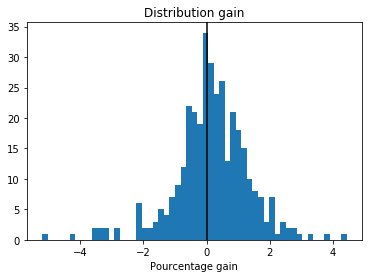

                                                           
-------------------- Croissance -----------------------


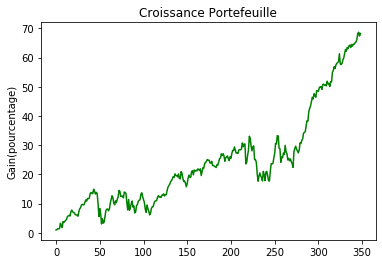

In [95]:
##### Gain obtenue sans SelectKBest
##### On prend les pourcentages du NQ100 pour calculer les gains
tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
matrice = mesure_classifieur(y_pred, tx_visu)


##### Gain obtenue avec SelectKBest
##### On prend les pourcentages du NQ100 pour calculer les gains
tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
matrice = mesure_classifieur(y_skb, tx_visu)

##### 9.2.2 Réglages hyper-paramètres

In [66]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)


In [67]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

parametre = {"max_iter" : [10, 100, 1000, 10000, 100000],
            "epsilon": [0.05, 0.1, 0.15]}

def metric(y, y_pred):
    y = y.reshape(len(y),1)
    y_pred = y_pred.reshape(len(y_pred),1)
    
    return pds.DataFrame(np.concatenate((y,y_pred),axis=1)).corr().values[0][1]

from sklearn.metrics import make_scorer
metric_sklearn = make_scorer(metric, greater_is_better=True)

grid = GridSearchCV(LinearSVR(), param_grid=parametre, scoring=metric_sklearn)
grid.fit(Xtrain_sc,ytrain_sc)

meilleur_modele = grid.best_estimator_



In [68]:
y_grid = meilleur_modele.predict(Xvisu_sc)
y_grid = y_grid.reshape(len(y_grid),1)

------------------ Données de bases -----------------------
Seuil_hausse: 0.0
Seuil_baisse: 0.0
Spred 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 56.66 %
Poucentage composé: 71.93 %
Ratio gain par trade: 0.16 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.137278
Ratio Sortino: 0.214617
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 37.72 %
Somme des gains à la baisse: 18.94 %
gain max a la hausse: 4.43 %
gain min a la hausse: -3.62 %
gain max a la baisse: 5.1 %
gain min a la baisse: -2.82 %
                                                           
-------------------- Distribution -----------------------


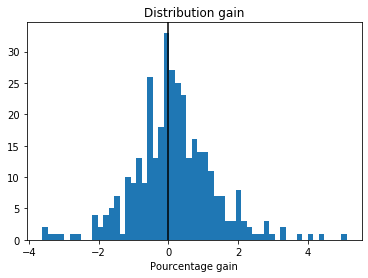

                                                           
-------------------- Croissance -----------------------


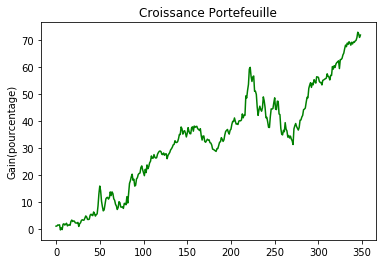

In [69]:
mesure_gain(y_grid, y_visu)

##### 9.2.2 Validation croisée pour la finance

In [102]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

def visu_gain(tx_pred, tx_visu, sb=0.00, sh=0.00, spread=0.00050, levier=1):
    # Initialisation
    l = len(tx_pred)
    gain = np.zeros(l).reshape(l,1)
    hausse = np.zeros(l).reshape(l,1)
    baisse = np.zeros(l).reshape(l,1)
    count_true = 0
    count_false = 0
    p = 0
    
    #Gain
    for i in range(l):
        if tx_pred[i][0]>sh:
            gain[i][0] = (tx_visu[i][0]-spread)*levier
            hausse[i][0] = (tx_visu[i][0]-spread)*levier
        if tx_pred[i][0]<-sb:
            gain[i][0] = (-tx_visu[i][0]-spread)*levier
            baisse[i][0] = (-tx_visu[i][0]-spread)*levier
    

    return (np.sum(gain)*100),(np.mean(gain[gain!=0])/np.std(gain[gain<0]))

In [141]:
matrice = np.concatenate((X, y), axis=1)

liste_gain = list()
liste_sortino = list()
n = 10
for i in range(1,n):
    j = len(X)//n
    matrice_ = matrice[j*i:j*(i+1),:]
    
    a = len(matrice_)*8//10
    l = len(matrice_)
    
    X_train = matrice_[0:a-1,0:8]
    X_visu = matrice_[a:l-1,0:8]

    y_train = matrice_[1:a,8:9]
    y_visu = matrice_[a+1:l,8:9]
    
    sc = StandardScaler()
    
    Xtrain_sc = sc.fit_transform(X_train)
    Xvisu_sc = sc.transform(X_visu)
    
    
    
    svr = LinearSVR(max_iter=1000000)
    svr.fit(Xtrain_sc, y_train)
    
    y_pred = svr.predict(Xvisu_sc)
    y_pred = y_pred.reshape(len(y_pred),1)
   
    
    liste_gain.append(visu_gain(y_pred, y_visu)[0])
    liste_sortino.append(visu_gain(y_pred, y_visu)[1])



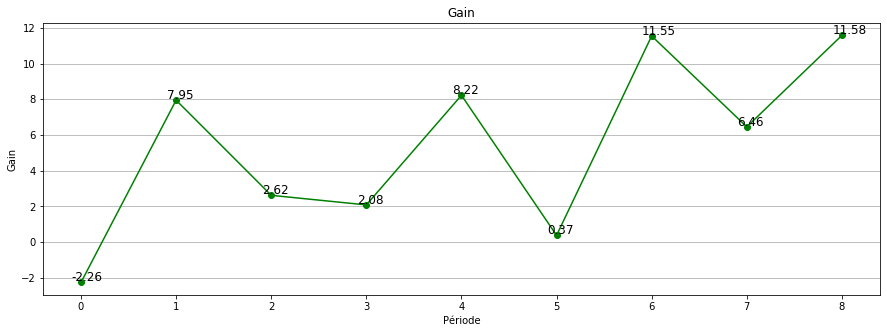

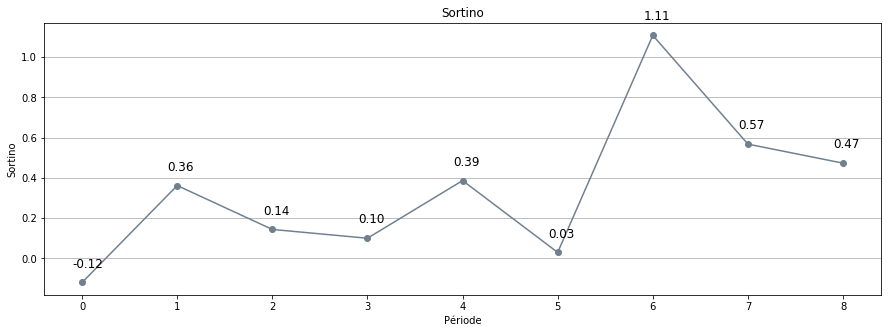

In [162]:
plt.figure(figsize=(15,5))
plt.grid(axis="y")
plt.plot(liste_gain, "o-", color="green")
plt.ylabel("Gain")
plt.xlabel("Période")
plt.title("Gain")
for i, j in zip([h for h in range(0,9)], liste_gain):
            label = "{:.2f}".format(j)
            plt.annotate(label, (i, j), xytext=(i-0.1, j+.075), fontsize=12)
plt.show()

plt.figure(figsize=(15,5))
plt.grid(axis="y")
plt.plot(liste_sortino, "o-", color="slategrey")
plt.ylabel("Sortino")
plt.xlabel("Période")
plt.title("Sortino")
for i, j in zip([h for h in range(0,9)], liste_sortino):
            label = "{:.2f}".format(j)
            plt.annotate(label, (i, j), xytext=(i-0.1, j+.075), fontsize=12)
plt.show()

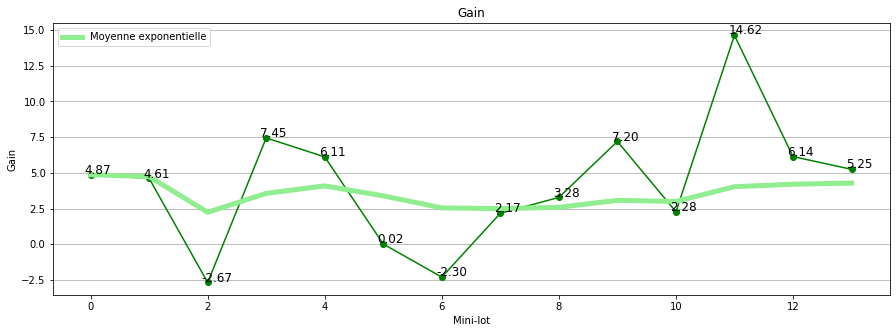

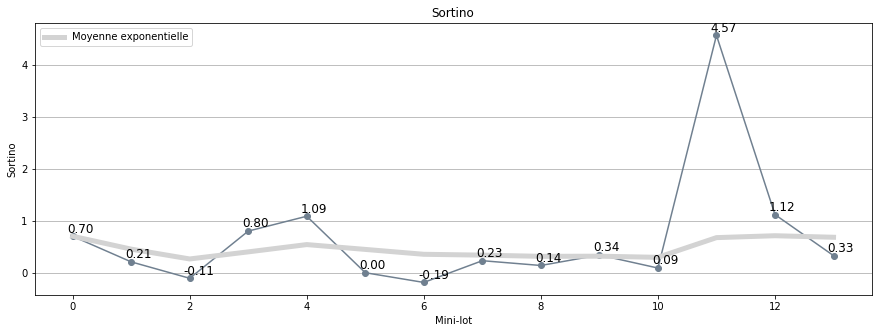

In [159]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets[["NQ100"]].pct_change(1).dropna().reset_index(drop=True)

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

##### Entrainement de la standardisation et application
ytrain_sc = sc.fit_transform(y_train)

from sklearn.svm import LinearSVR
rl = LinearSVR(max_iter=100000, C=5.5)

rl.fit(Xtrain_sc, ytrain_sc)
y_pred = sc.inverse_transform(rl.predict(Xvisu_sc))

y_pred = y_pred.reshape(len(y_pred),1)


matrice = np.concatenate((y_pred, y_visu), axis=1)

liste_gain = list()
liste_sortino = list()
n = 15
for lot in range(1,n):
    taille = len(matrice)//n
    matrice_ = matrice[taille*lot:taille*(lot+1),:]
    
    liste_gain.append(visu_gain(matrice_[:,0:1], matrice_[:,1:2])[0])
    liste_sortino.append(visu_gain(matrice_[:,0:1], matrice_[:,1:2])[1])

plt.figure(figsize=(15,5))
plt.grid(axis="y")
plt.plot(liste_gain, "o-", color="green")
plt.ylabel("Gain")
plt.xlabel("Mini-lot")
plt.plot(pds.DataFrame(np.array(liste_gain)).ewm(com=85).mean().values, color="lightgreen", linewidth=5, label="Moyenne exponentielle")
plt.legend()
plt.title("Gain")
for i, j in zip([h for h in range(0,n-1)], liste_gain):
            label = "{:.2f}".format(j)
            plt.annotate(label, (i, j), xytext=(i-0.1, j+.075), fontsize=12)
plt.show()

plt.figure(figsize=(15,5))
plt.grid(axis="y")
plt.plot(liste_sortino, "o-", color="slategrey")
plt.ylabel("Sortino")
plt.xlabel("Mini-lot")
plt.plot(pds.DataFrame(np.array(liste_sortino)).ewm(com=85).mean().values, color="lightgrey", linewidth=5, label="Moyenne exponentielle")
plt.legend()
plt.title("Sortino")
for i, j in zip([h for h in range(0,n-1)], liste_sortino):
            label = "{:.2f}".format(j)
            plt.annotate(label, (i, j), xytext=(i-0.1, j+.075), fontsize=12)
plt.show()

##### Effet de la standardisation sur les performances

------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 54.52 %
Poucentage composé: 68.25 %
Ratio gain par trade: 0.16 %
Écart-type des gains: 1.18 %
Ratio Sharpe: 0.131967
Ratio Sortino: 0.169633
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 33.85 %
Somme des gains à la baisse: 20.67 %
gain max a la hausse: 4.43 %
gain min a la hausse: -5.2 %
gain max a la baisse: 2.92 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -------------------------


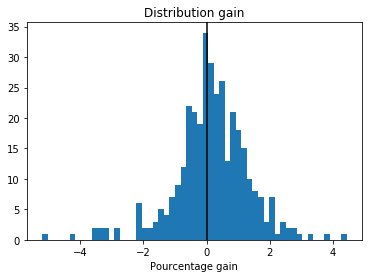

                                                           
-------------------- Croissance ---------------------------


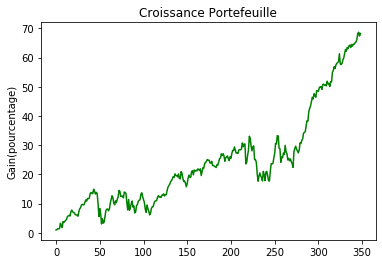

In [97]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT",
              "DJI30", "DAX30", "GOLD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain_sc, y_train)
y_pred = lr.predict(Xvisu_sc)
y_pred = y_pred.reshape(len(y_skb),1)

tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
matrice = mesure_classifieur(y_pred, tx_visu)

------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 24.57 %
Poucentage composé: 24.68 %
Ratio gain par trade: 0.07 %
Écart-type des gains: 1.2 %
Ratio Sharpe: 0.05888
Ratio Sortino: 0.074592
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 16.58 %
Somme des gains à la baisse: 7.99 %
gain max a la hausse: 4.43 %
gain min a la hausse: -5.2 %
gain max a la baisse: 2.48 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -------------------------


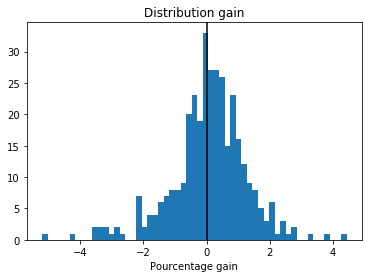

                                                           
-------------------- Croissance ---------------------------


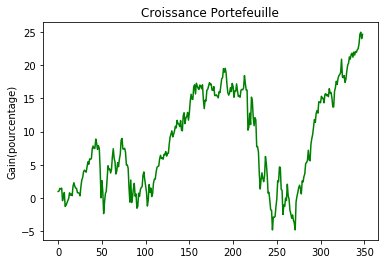

In [98]:
##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT",
              "DJI30", "DAX30", "GOLD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain_sc, y_train)
y_pred = lr.predict(Xvisu_sc)
y_pred = y_pred.reshape(len(y_skb),1)

tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
matrice = mesure_classifieur(y_pred, tx_visu)

##### 9.3 Méthodes Ensemblistes

In [7]:
datasets_pct = datasets.pct_change(1).dropna().reset_index(drop=True)
datasets_pct["Étiquetage"] = np.round(datasets_pct["NQ100"]+0.5)

##### Scindage de la base de données en X et y
X = datasets[["AMZN", "BRENT", "CAC40","NQ100",
              "DJI30", "DAX30", "GOLD", "EURUSD"]].pct_change(1).dropna().reset_index(drop=True)
y = datasets_pct[["Étiquetage"]]

##### Scindage en en jeu de train et jeu de visualisation
##### On met un intervalle d'écart de une période
X_train = X.iloc[0:1400-1,:].values
X_visu = X.iloc[1400:1750-1,:].values

y_train = y.iloc[1:1400,:].values
y_visu = y.iloc[1400+1:1750,:].values

##### Importation de la fonction de standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##### Entrainement de la standardisation et application
Xtrain_sc = sc.fit_transform(X_train)

##### Application de la standardisation
Xvisu_sc = sc.transform(X_visu)


------------------ Données de bases -----------------------
Spread 0.0005
Effet de levier: 1
                                                           
---------------------- Mesures ----------------------------
Pourcentage sur la période: 70.76 %
Poucentage composé: 97.96 %
Ratio gain par trade: 0.2 %
Écart-type des gains: 1.17 %
Ratio Sharpe: 0.172594
Ratio Sortino: 0.241137
                                                           
-------------------- Autres données -----------------------
Somme des gains à la hausse: 42.42 %
Somme des gains à la baisse: 28.34 %
gain max a la hausse: 4.43 %
gain min a la hausse: -5.2 %
gain max a la baisse: 4.07 %
gain min a la baisse: -2.14 %
                                                           
-------------------- Distribution -------------------------


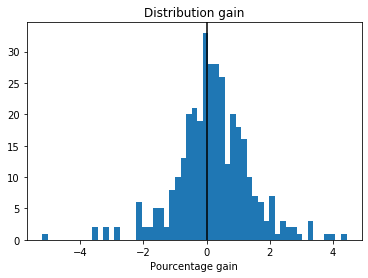

                                                           
-------------------- Croissance ---------------------------


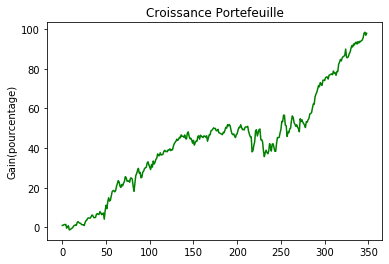

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
classificateur = [("Lr",LogisticRegression()),
                 ("LSVC",LinearSVC(max_iter=10000)),
                 ("SVC", SVC(max_iter=100000)),
                 ("RFC", RandomForestClassifier()),
                 ("GBC", GradientBoostingClassifier())]

cl = VotingClassifier(estimators=classificateur, voting="hard")
cl.fit(Xtrain_sc,y_train)

y_pred = cl.predict(Xvisu_sc)


tx_visu = datasets_pct[["NQ100"]].iloc[1400+1:1750,:].values
mesure_classifieur(y_pred, tx_visu)